In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

history_df = pd.read_sql('SELECT * FROM player_history', sqlite3.connect('steam_top100_with_names.db'))
games_df = pd.read_sql('SELECT * FROM games', sqlite3.connect('steam_top100_with_names.db'))
combined_df = pd.merge(history_df, games_df, on='appid')
combined_df

,appid,month,avg_players,peak_players,year,month_num,game_name
0,730,Last 30 Days,914682.70,1427300,2025,8,Counter-Strike 2
1,730,July 2025,920069.98,1427300,2025,7,Counter-Strike 2
2,730,June 2025,1010123.99,1725815,2025,6,Counter-Strike 2
3,730,May 2025,1038596.81,1712216,2025,5,Counter-Strike 2
4,730,April 2025,1045701.65,1811827,2025,4,Counter-Strike 2
...,...,...,...,...,...,...,...
2338,221100,January 2013,0.42,4,2013,1,DayZ
2339,221100,December 2012,0.33,5,2012,12,DayZ
2340,221100,November 2012,0.46,5,2012,11,DayZ
2341,221100,October 2012,0.13,3,2012,10,DayZ


Practice grouping data bu names and plotting them

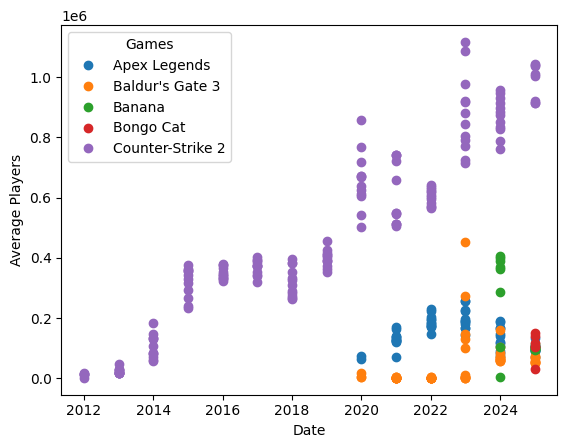

In [288]:
names = combined_df.groupby('game_name')
fig, ax = plt.subplots()
for name, g in list(names)[:5]:
    ax.plot(g["year"], g["avg_players"], marker="o", linestyle="", label=name)  # scatter
ax.set_xlabel("Date")        # rename as needed
ax.set_ylabel("Average Players")
ax.legend(title="Games")
plt.show()


Visualize the average player trends from the games created in 2012

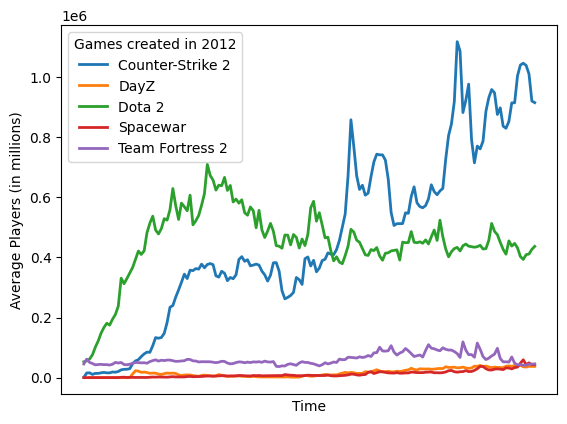

In [289]:
conn = sqlite3.connect('steam_top100_with_names.db')
df_2012 = pd.read_sql("""
    SELECT 
        g.game_name,
        g.appid,
        ph.month,
        ph.avg_players,
        ph.peak_players,
        ph.year
    FROM games g
    JOIN player_history ph ON g.appid = ph.appid
    WHERE g.appid IN (
        SELECT  appid
        FROM player_history
        GROUP BY appid
        HAVING MIN(year) = 2012
    )
    ORDER BY g.game_name, ph.year, ph.month_num;
""", conn)
names = df_2012.groupby('game_name')
fig, ax = plt.subplots()
for name, g in list(names)[:]:
    ax.plot(g["month"], g["avg_players"], marker="", linewidth=2, label=name)  # scatter
ax.set_xlabel("Time")        # rename as needed
ax.set_ylabel("Average Players (in millions)")
ax.legend(title="Games created in 2012")
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.show()

Visualize the average player trends from the games created in 2013

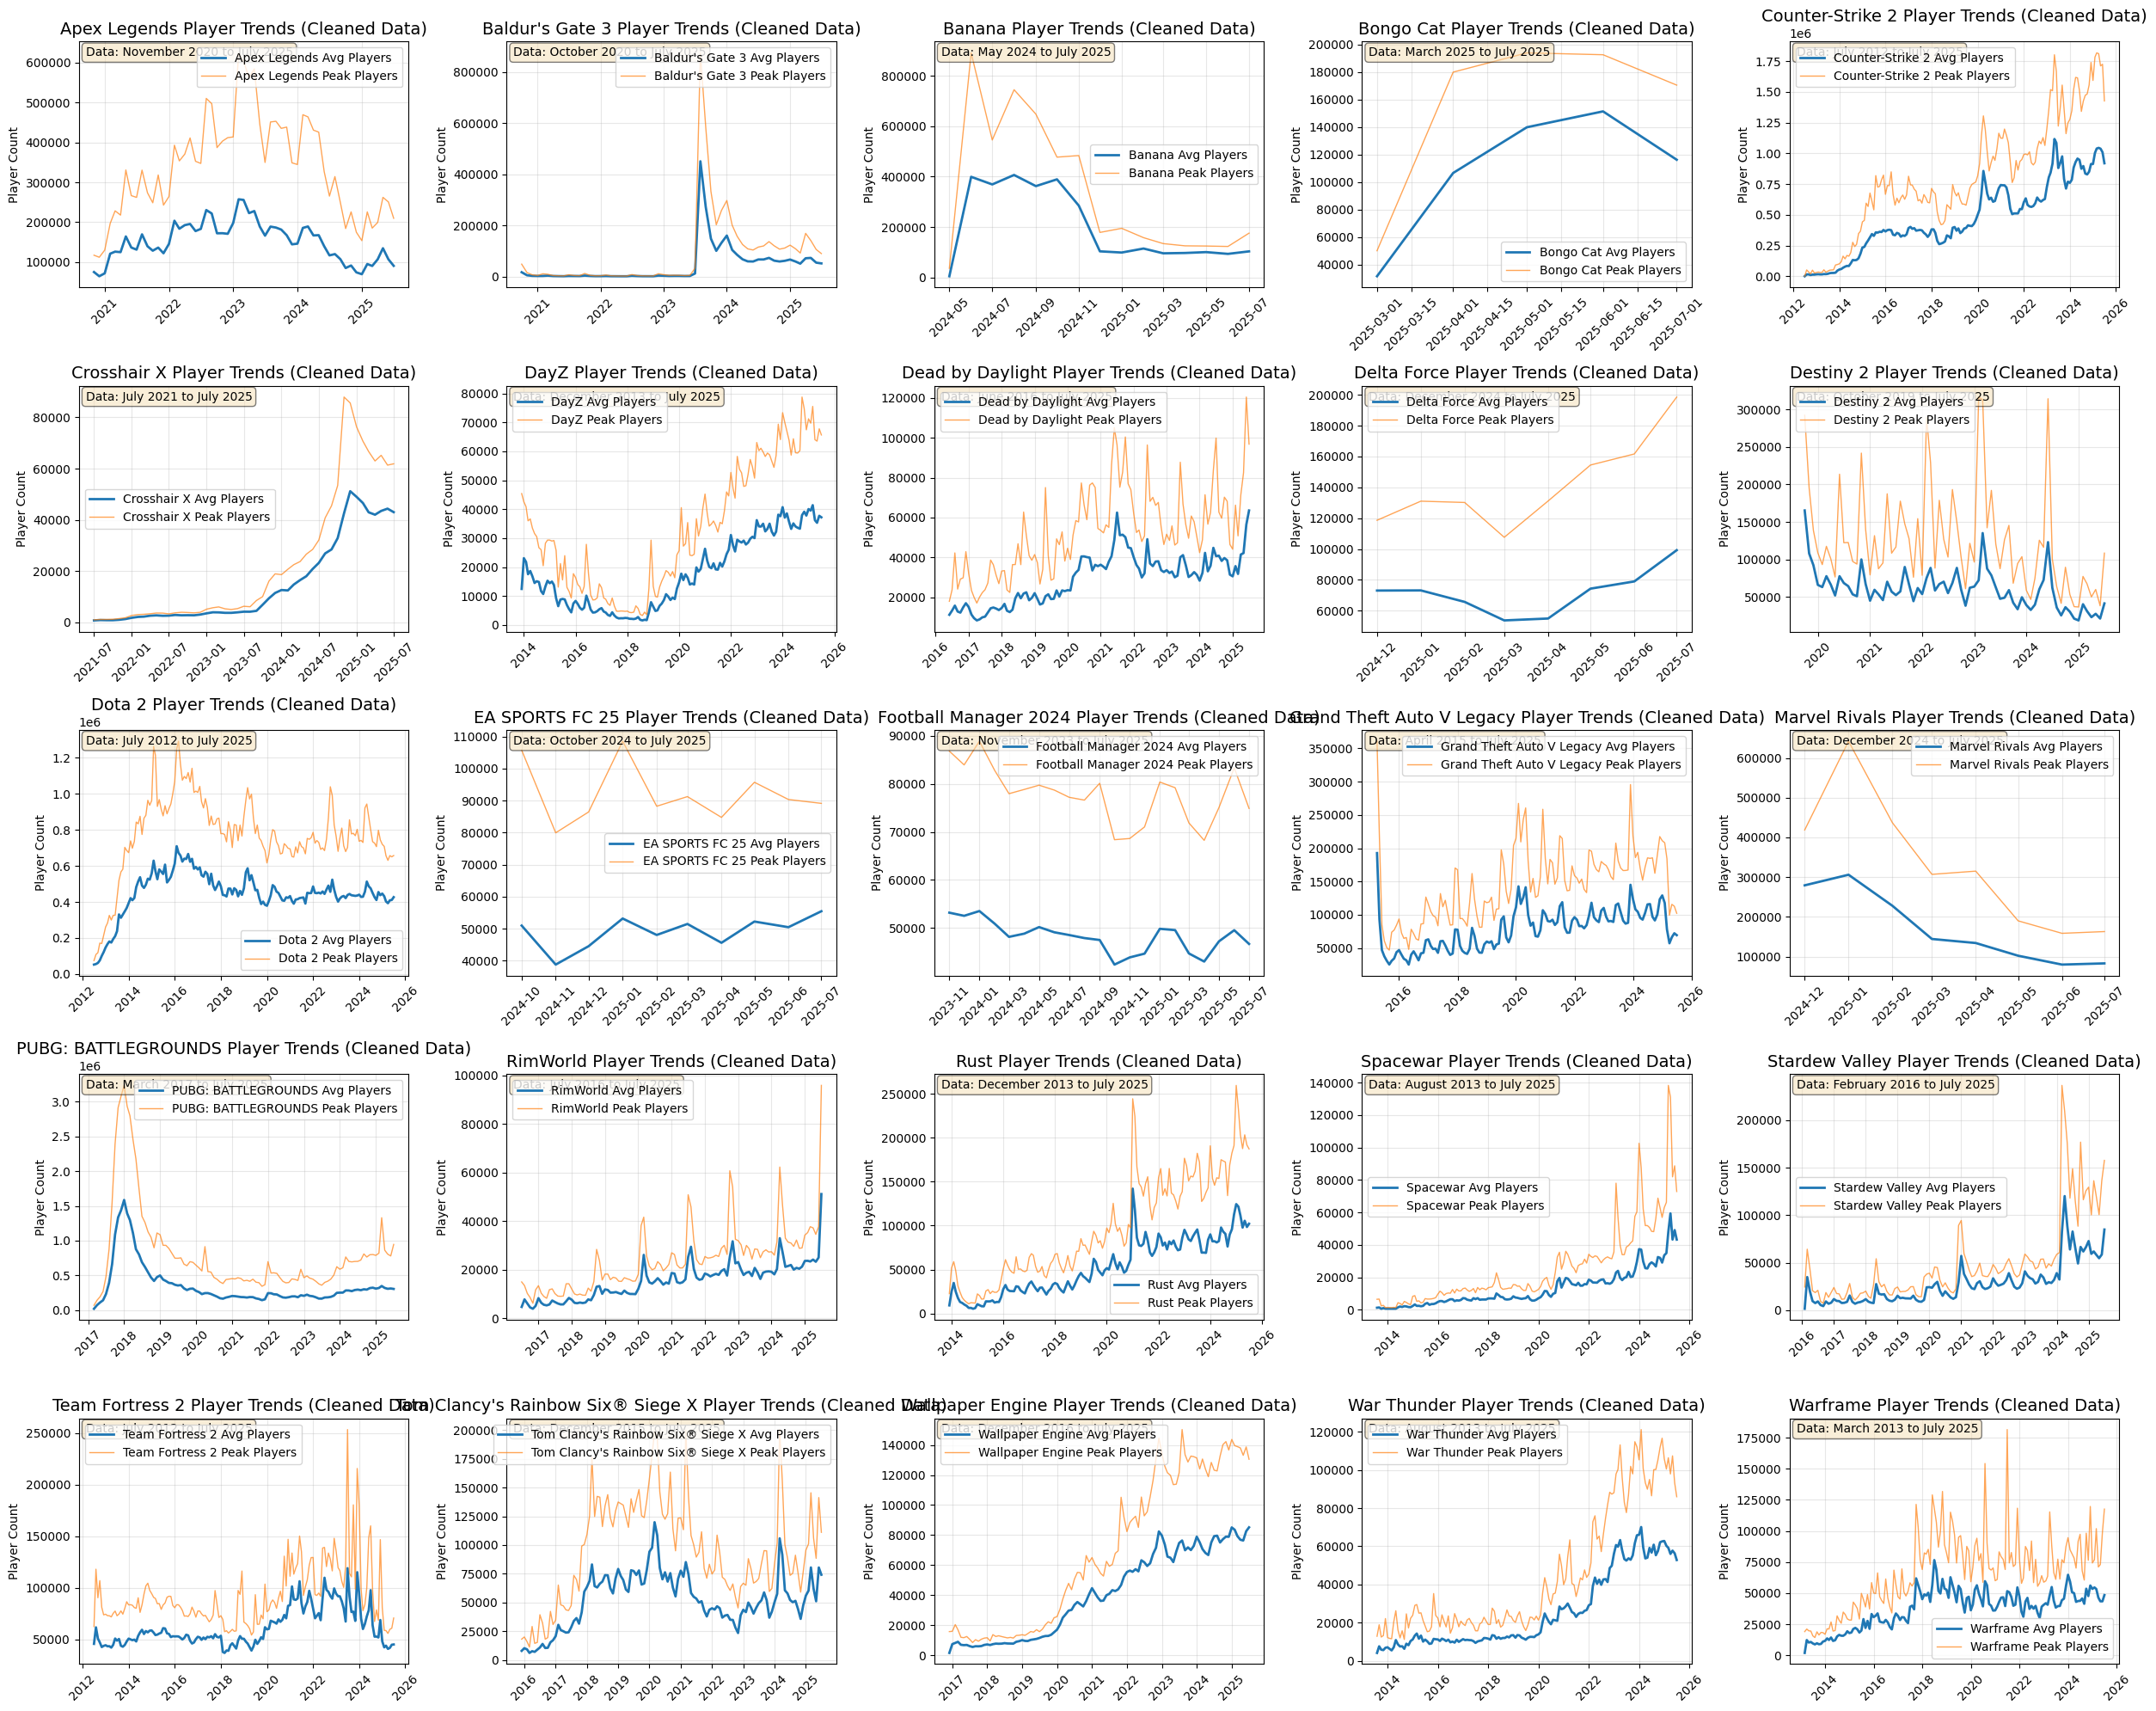

In [290]:
conn = sqlite3.connect('steam_data_cleaned.db')
df = pd.read_sql("""
    SELECT 
        g.game_name,
        g.appid,
        ph.month,
        ph.avg_players,
        ph.peak_players,
        ph.year
    FROM games g
    JOIN player_history ph ON g.appid = ph.appid
    WHERE g.appid IN (
        SELECT  appid
        FROM player_history
        GROUP BY appid
    )
    ORDER BY g.game_name, ph.year, ph.month_num;
""", conn)

games_to_plot = [games for games in df['game_name'].unique()]
num_games = len(games_to_plot)
# Calculate optimal subplot layout
if num_games == 1:
    rows, cols = 1, 1
elif num_games == 2:
    rows, cols = 1, 2
elif num_games <= 4:
    rows, cols = 2, 2
elif num_games <= 6:
    rows, cols = 2, 3
elif num_games <= 9:
    rows, cols = 3, 3
elif num_games <= 12:
    rows, cols = 3, 4
elif num_games <= 15:
    rows, cols = 3, 5
elif num_games <= 20:
    rows, cols = 4, 5
elif num_games <= 25:
    rows, cols = 5, 5
else:
    rows, cols = 5, 5  # Maximum 25 subplots
fig_width = cols * 5
fig_height = rows * 4
plt.figure(figsize=(fig_width, fig_height))
for i, game_name in enumerate(games_to_plot, 1):
    game_data = df[df['game_name'] == game_name].copy()
        
    if game_data.empty:
        print(f"No data found for {game_name}")
        continue
            
    # Convert month to datetime and sort
    game_data['date'] = pd.to_datetime(game_data['month'], format='%B %Y', errors='coerce')
    game_data = game_data.sort_values('date')
        
        # Create subplot
    plt.subplot(rows, cols, i)
    plt.plot(game_data['date'], game_data['avg_players'], linewidth=2, label=f'{game_name} Avg Players')
    plt.plot(game_data['date'], game_data['peak_players'], linewidth=1, alpha=0.7, label=f'{game_name} Peak Players')
        
    plt.title(f'{game_name} Player Trends (Cleaned Data)', fontsize=14)
    plt.ylabel('Player Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
        
        # Clean up x-axis
    plt.xticks(rotation=45)
        
        # Show data range info
    start_date = game_data['date'].min().strftime('%B %Y')
    end_date = game_data['date'].max().strftime('%B %Y')
    plt.text(0.02, 0.98, f'Data: {start_date} to {end_date}', 
            transform=plt.gca().transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
plt.tight_layout()
plt.show()

Future player prediction starting with CSGO; creating the dataframe and training data

In [292]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

conn = sqlite3.connect('steam_data_cleaned.db')
df = pd.read_sql("""SELECT
    g.game_name,
    ph.avg_players,
    ph.peak_players,
    ph.date
FROM games g
JOIN player_history ph ON g.appid = ph.appid
WHERE g.game_name = 'Counter-Strike 2'
ORDER BY ph.date;
""", conn)
df = df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df["lag1"]  = df["avg_players"].shift(1)
df["lag2"]  = df["avg_players"].shift(2)
df["ma3"]   = df["avg_players"].shift(1).rolling(3).mean()
df["month"] = df["date"].dt.month
feat_cols = ["lag1", "lag2", "ma3", "month"]
df_feat = df.dropna(subset=feat_cols + ["avg_players"]).reset_index(drop=True)
df_feat_peek = df_feat[["date","avg_players"] + feat_cols]
df_feat_peek




,date,avg_players,lag1,lag2,ma3,month
0,2012-10-01,10739.48,16000.75,15475.39,1.080290e+04,10
1,2012-11-01,14134.10,10739.48,16000.75,1.407187e+04,11
2,2012-12-01,14079.39,14134.10,10739.48,1.362478e+04,12
3,2013-01-01,16164.22,14079.39,14134.10,1.298432e+04,1
4,2013-02-01,17372.73,16164.22,14079.39,1.479257e+04,2
...,...,...,...,...,...,...
150,2025-04-01,1045701.65,1039662.81,1003570.56,9.857752e+05,4
151,2025-05-01,1038596.81,1045701.65,1039662.81,1.029645e+06,5
152,2025-06-01,1010123.99,1038596.81,1045701.65,1.041320e+06,6
153,2025-07-01,920069.98,1010123.99,1038596.81,1.031474e+06,7


Creating the subset dataframes for the training data, validation data, and test data

In [ ]:
N_VAL = 6
N_TEST = 2
n = len(df_feat)
test  = df_feat.iloc[-N_TEST:].copy()                       # last 2 months
val   = df_feat.iloc[-(N_TEST+N_VAL):-N_TEST].copy()     # the 2 months before test
train = df_feat.iloc[:-(N_TEST+N_VAL)].copy()

print("Train:", train["date"].min().date(), "→", train["date"].max().date(), "rows:", len(train))
print("Val:  ",   val["date"].min().date(), "→",   val["date"].max().date(), "rows:", len(val))
print("Test: ",  test["date"].min().date(), "→",  test["date"].max().date(), "rows:", len(test))

Train: 2012-10-01 → 2024-12-01 rows: 147
Val:   2025-01-01 → 2025-06-01 rows: 6
Test:  2025-07-01 → 2025-08-01 rows: 2


Seperate the training and validation metrics from target variable, being average players

In [296]:
target = "avg_players"
feat_cols = ["lag1", "lag2", "ma3", "month"]

# Build X/y
X_train, y_train = train[feat_cols].to_numpy(), train[target].to_numpy()
X_val,   y_val   =   val[feat_cols].to_numpy(),   val[target].to_numpy()
X_test,  y_test  =  test[feat_cols].to_numpy(),  test[target].to_numpy()

# Quick checks
print("Shapes — X_train, y_train:", X_train.shape, y_train.shape)
print("Shapes — X_val,   y_val  :", X_val.shape,   y_val.shape)
print("Shapes — X_test,  y_test :", X_test.shape,  y_test.shape)

# No missing values?
print("NaNs in X_train:", np.isnan(X_train).sum(), "| NaNs in y_train:", np.isnan(y_train).sum())
print("NaNs in X_val  :", np.isnan(X_val).sum(),   "| NaNs in y_val  :", np.isnan(y_val).sum())
print("NaNs in X_test :", np.isnan(X_test).sum(),  "| NaNs in y_test :", np.isnan(y_test).sum())


Shapes — X_train, y_train: (147, 4) (147,)
Shapes — X_val,   y_val  : (6, 4) (6,)
Shapes — X_test,  y_test : (2, 4) (2,)
NaNs in X_train: 0 | NaNs in y_train: 0
NaNs in X_val  : 0 | NaNs in y_val  : 0
NaNs in X_test : 0 | NaNs in y_test : 0


Finding the MAPE using lag1 to compare our linear regression model to the actual data. This works since we get to weigh how helpful our model is to just comparing a future prediction to "just last month's" data.

In [297]:

def eval_metrics(y_true, y_pred, label=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # MAPE guarded against zeros
    mape = np.mean(np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0.0)) * 100
    print(f"{label}MAE:  {mae:,.2f}")
    print(f"{label}RMSE: {rmse:,.2f}")
    print(f"{label}MAPE: {mape:,.2f}%")

# Baseline (naive) using lag1 -> predict current month
y_val_pred_naive = val["lag1"].to_numpy()

print("=== Baseline (lag1 -> predict current) on VALIDATION ===")
eval_metrics(y_val, y_val_pred_naive, label="")


=== Baseline (lag1 -> predict current) on VALIDATION ===
MAE:  27,887.66
RMSE: 41,244.58
MAPE: 2.75%


Visualize how correlated the data is and how significant outliers are.

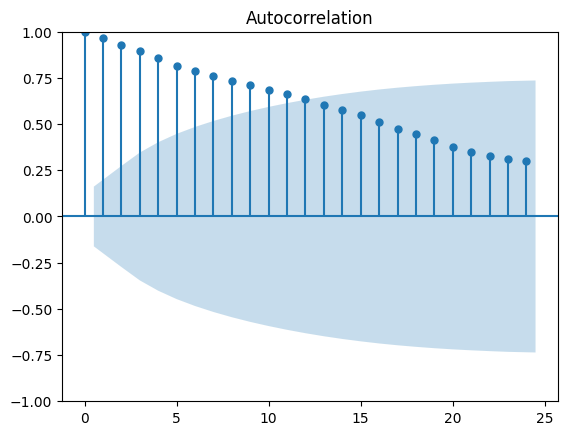

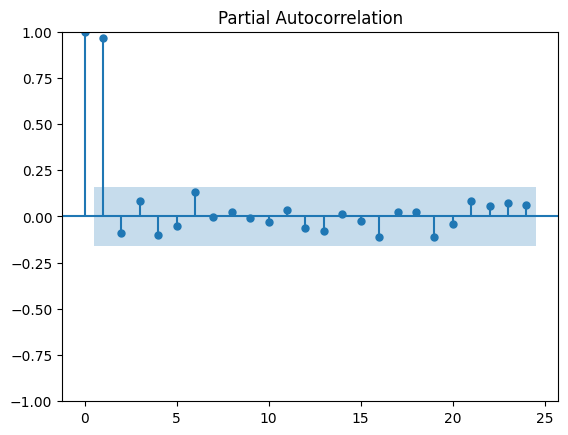

ACF (lags 1..12): [np.float64(0.966), np.float64(0.927), np.float64(0.894), np.float64(0.857), np.float64(0.817), np.float64(0.787), np.float64(0.76), np.float64(0.734), np.float64(0.709), np.float64(0.684), np.float64(0.661), np.float64(0.636)]
PACF (lags 1..12): [np.float64(0.966), np.float64(-0.091), np.float64(0.085), np.float64(-0.099), np.float64(-0.053), np.float64(0.132), np.float64(-0.002), np.float64(0.026), np.float64(-0.007), np.float64(-0.032), np.float64(0.034), np.float64(-0.063)]


In [299]:

series = train["avg_players"].to_numpy()

# Try statsmodels first; fall back to a simple numeric ACF if it's not installed
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import acf, pacf
    import matplotlib.pyplot as plt
    use_sm = True
except Exception:
    use_sm = False

if use_sm:
    # Visuals (optional but nice if you're in a notebook)
    _ = plot_acf(series, lags=24)
    _ = plot_pacf(series, lags=24, method="ywm")  # Yule-Walker modified is stable
    plt.show()

    acf_vals  = acf(series, nlags=24, fft=True)
    pacf_vals = pacf(series, nlags=24, method="ywm")
else:
    # Minimal numeric ACF (no PACF fallback)
    def acf_numeric(x, max_lag):
        x = np.asarray(x, dtype=float)
        x = x - x.mean()
        denom = np.dot(x, x)
        out = [1.0]
        for k in range(1, max_lag + 1):
            out.append(np.dot(x[:-k], x[k:]) / denom)
        return np.array(out)
    acf_vals  = acf_numeric(series, 24)
    pacf_vals = None

print("ACF (lags 1..12):", [round(v, 3) for v in acf_vals[1:13]])
if pacf_vals is not None:
    print("PACF (lags 1..12):", [round(v, 3) for v in pacf_vals[1:13]])


Measure against LinearRegression

In [300]:

feat_cols = ["lag1", "lag2", "ma3", "month"]
target = "avg_players"

lr = LinearRegression()
lr.fit(X_train, y_train)

y_val_pred_lr = lr.predict(X_val)

print("=== LinearRegression on VALIDATION ===")
eval_metrics(y_val, y_val_pred_lr, label="LR ")

print("\nCoefficients (feature -> weight):")
for name, w in zip(feat_cols, lr.coef_):
    print(f"{name:>6} : {w:,.4f}")
print("Intercept:", f"{lr.intercept_:,.2f}")


=== LinearRegression on VALIDATION ===
LR MAE:  28,400.62
LR RMSE: 43,909.24
LR MAPE: 2.84%

Coefficients (feature -> weight):
  lag1 : 0.9892
  lag2 : -0.8770
   ma3 : 0.8756
 month : -1,332.7383
Intercept: 20,308.89


LinearRegression did not beat the lag-1 baseline; testing the actual state of colinearality

In [301]:
# 1) Correlation matrix on TRAIN (to see redundancy)
cols = ["avg_players","lag1","lag2","ma3","month"]
print(train[cols].corr(numeric_only=True).round(3))

# 2) Condition number (big = collinearity)
X_tr = train[["lag1","lag2","ma3","month"]].to_numpy()
u, s, vh = np.linalg.svd(X_tr, full_matrices=False)
cond = s.max() / s.min()
print("Condition number:", round(cond, 1))


             avg_players   lag1   lag2    ma3  month
avg_players        1.000  0.985  0.963  0.972 -0.039
lag1               0.985  1.000  0.985  0.990 -0.021
lag2               0.963  0.985  1.000  0.997  0.022
ma3                0.972  0.990  0.997  1.000  0.020
month             -0.039 -0.021  0.022  0.020  1.000
Condition number: 186412.2


Since the lag2 and ma3 are so similar to lag1, they dont add much value to the model except add noise. Lets try with just lag1 to see if linear regression can do a better job than the baseline.

In [302]:

target = "avg_players"
feat_cols_s1 = ["lag1"]

lr1 = LinearRegression()
lr1.fit(train[feat_cols_s1], train[target])

y_val_pred_lr1 = lr1.predict(val[feat_cols_s1])

print("=== LR(lag1 only) on VALIDATION ===")
eval_metrics(y_val, y_val_pred_lr1, label="LR1 ")

print("\nCoefficient(s):")
for name, w in zip(feat_cols_s1, lr1.coef_):
    print(f"{name}: {w:,.6f}")
print("Intercept:", f"{lr1.intercept_:,.2f}")


=== LR(lag1 only) on VALIDATION ===
LR1 MAE:  27,901.00
LR1 RMSE: 41,373.22
LR1 MAPE: 2.75%

Coefficient(s):
lag1: 0.986326
Intercept: 12,177.75


Adding seasonal analysis to the data, making the weight of the dates cyclic

In [303]:


# Create cyclical month features (safe—based only on date)
for dfp in (train, val, test):
    dfp["month_sin"] = np.sin(2 * np.pi * dfp["month"] / 12.0)
    dfp["month_cos"] = np.cos(2 * np.pi * dfp["month"] / 12.0)

target = "avg_players"
feat_cols_s2 = ["lag1", "month_sin", "month_cos"]

lr_seasonal = LinearRegression()
lr_seasonal.fit(train[feat_cols_s2], train[target])

y_val_pred_lr_seasonal = lr_seasonal.predict(val[feat_cols_s2])

print("=== LR(lag1 + cyc month) on VALIDATION ===")
eval_metrics(y_val, y_val_pred_lr_seasonal, label="LR+Season ")

print("\nCoefficients:")
for name, w in zip(feat_cols_s2, lr_seasonal.coef_):
    print(f"{name:>9}: {w:,.4f}")
print("Intercept:", f"{lr_seasonal.intercept_:,.2f}")


=== LR(lag1 + cyc month) on VALIDATION ===
LR+Season MAE:  21,917.12
LR+Season RMSE: 31,994.90
LR+Season MAPE: 2.20%

Coefficients:
     lag1: 0.9893
month_sin: 13,183.0503
month_cos: 12,272.4430
Intercept: 10,798.25


C:\Users\jcelm\AppData\Local\Temp\ipykernel_47668\2226059990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["month_sin"] = np.sin(2 * np.pi * dfp["month"] / 12.0)
C:\Users\jcelm\AppData\Local\Temp\ipykernel_47668\2226059990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp["month_cos"] = np.cos(2 * np.pi * dfp["month"] / 12.0)
C:\Users\jcelm\AppData\Local\Temp\ipykernel_47668\2226059990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using